# Install necessary packages and importing

In [1]:
import functools
import jax
import jax.numpy as jnp
import torch
import optax
import matplotlib.pyplot as plt
import flax
from flax.training import train_state, checkpoints
import flax.linen as nn
from flax.training import train_state

from algebra.cliffordalgebra import CliffordAlgebra
#from modules.conv.kernel import CliffordSteerableKernel
#from modules.conv.ckernel import ComposedCliffordSteerableKernel
#from modules.conv.condkernel import CondCliffordSteerableKernel
#from modules.conv.convolution import CliffordSteerableConv, ConditionedCliffordSteerableConv, BatchlessConditionedCliffordSteerableConv
from modules.conv.altconv import ConditionedCliffordSteerableConv, BatchlessConditionedCliffordSteerableConv

from escnn import gspaces, group

RNG_ID = 42
# disable 64
jax.config.update("jax_enable_x64", False)

# Plotting trained kernels

## 1. Loading the trained params

In [5]:
# Mounting drive (optional)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
checkpoint_dir = "/content/drive/MyDrive/composed-exp/checkpoints/bcf87sod/986"

In [ ]:
# Loading the checkpoint
state = checkpoints.restore_checkpoint(
    ckpt_dir=checkpoint_dir,
    target=None,
    prefix='default',
    step=None
)

# Extract the parameters
if state is None:
    print("Checkpoint could not be loaded.")
else:
    params = state['params'] if 'params' in state else state
    print(params.keys())

In [ ]:
# Slicing into the parameters to get the desired objects
kernel_params = params['model']['params']['CSBasicBlock_0']['ConditionedCliffordSteerableConv_0']['BatchlessConditionedCliffordSteerableConv_0']['CondCliffordSteerableKernel_0']#['WeightedCayley_0']['weight']#['BatchlessConditionedCliffordSteerableConv_0']['CondCliffordSteerableKernel_0']["WeightedCayley_0"]["weight"]

print(kernel_params.keys())

# this is necessary for initialisation
kernel_params = {'params': kernel_params}

dict_keys(['KernelNetwork_0', 'ScalarShell_0', 'WeightedCayley_0', 'rel_pos_sigma'])
dict_keys(['CondCliffordSteerableKernel_0', 'bias'])


## 2. Initialising the kernel with the trained params

Defining the masking functions

In [ ]:
def create_circular_mask(diameter, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = ((diameter-1)/2, (diameter-1)/2)
    if radius is None:
        radius = min(center[0], center[1], diameter-center[0], diameter-center[1])

    Y, X = jnp.ogrid[:diameter, :diameter]
    dist_from_center = jnp.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask.astype(float)

def pool(x, circular_mask):
    return (x * circular_mask[None, :, :, None]).mean((1, 2)) # pool the image into one vector; image has shape [C,X_1,X_2,n_blades] (no batch!)

In [3]:
# Getting algebra object
algebra = CliffordAlgebra((1,1))

In [4]:
kernel_size = 11
c_in = 48
c_out = 48


# Config for instantiation
config = dict(
    algebra=algebra,
    kernel_size=kernel_size,
    c_in=c_in,
    c_out=c_out,
    num_layers=4,
    hidden_dim=12,
    bias_dims=(0,),
    product_paths_sum=algebra.geometric_product_paths.sum().item(),
)

In [ ]:
# instantiation
cond_kernel = CondCliffordSteerableKernel(**config)

## 3. Optaining condition from an NS datapoint

Defining padding function (necessary for plotting)

In [ ]:
def preprocess_data_ns(data, clifford):
    if clifford:
        # Concatenate zeros to the tensor
        zero_pad = torch.zeros(data.shape[:-1] + (1,))
        data = torch.cat((data, zero_pad), dim=-1)

    return data

Loading data from (drive) folder

In [ ]:
# Specify the path to the .pt file you want to load
pt_file_path = "/content/drive/MyDrive/composed-exp/test/115.pt"

# Load the data from the .pt file
data_tensor = torch.load(pt_file_path)  # Shape: (T, 64, 64, C)

print("Loaded data tensor shape:", data_tensor.shape)

Loaded data tensor shape: torch.Size([14, 64, 64, 3])


<ipython-input-74-e92309c09fa8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_tensor = torch.load(pt_file_path)  # Shape: (T, 64, 64, C)


In [ ]:
# Extracting the data for num_timesteps
num_timepoints = c_in

if data_tensor.shape[0] < num_timepoints:
    raise ValueError(f"Not enough timepoints available. Requested {num_timepoints}, but the tensor only has {data_tensor.shape[0]}.")
condition_timesteps = data_tensor[:num_timepoints]  # Shape: (4, 64, 64, 3)

print("Condition timesteps shape:", condition_timesteps.shape)

ValueError: Not enough timepoints available. Requested 48, but the tensor only has 14.

We need to pad the pseudoscalar part with zeros since the data doesn't contain that part.

We also transform the torch tensor to a jax array

In [ ]:
# Padding the data
input_padded = preprocess_data_ns(condition_timesteps, True)
print(input_padded.shape)

# Moving torch tensor to jax
input = jnp.array(input_padded)
print(input.shape)

torch.Size([4, 64, 64, 4])
(4, 64, 64, 4)


Now we need to obtain the condition from the input

In [ ]:
# Create the circular mask
circular_mask = create_circular_mask(input.shape[-2]) #we need the diamater to be the same size as the domain dims

# Obtain condition
condition = pool(input, circular_mask)

print("Shape of the condition", condition.shape)

Shape of the condition (4, 4)


In [ ]:
init = cond_kernel.apply(kernel_params, condition)

ValueError: Size of label 'm' for operand 1 (5) does not match previous terms (49).

## 4. Plotting the trained kernels

Now we visualise the trained kernels for each input and output channel, conditioning on the sample from the NS testing dataset

(192, 16, 128, 128)
(4, 4, 128, 128)


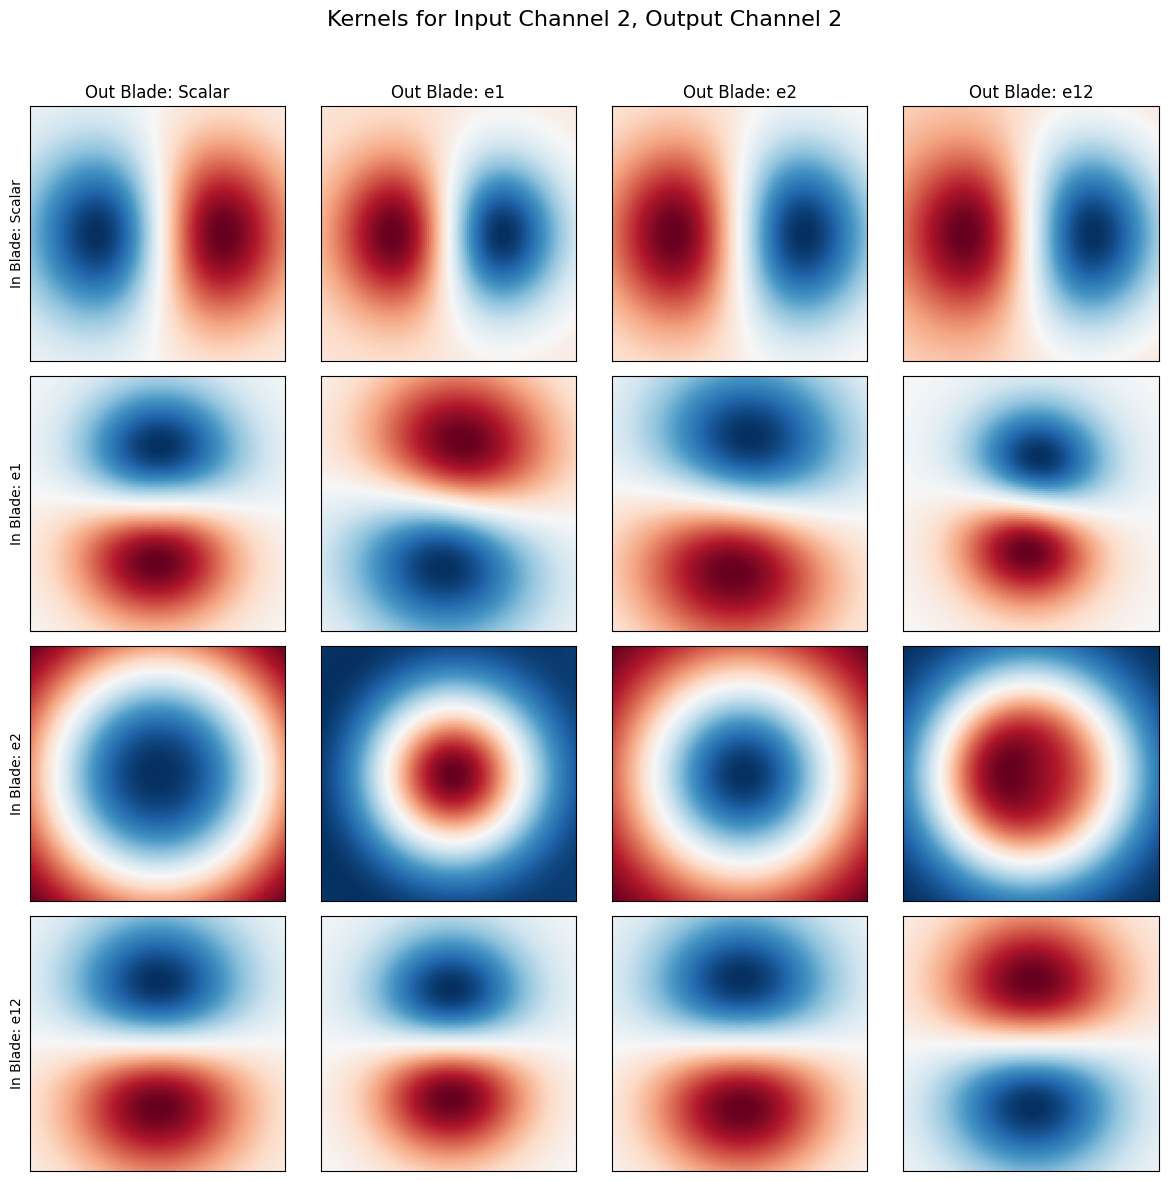

In [ ]:
kernel_tensor = init.reshape(48, 4, 4, 4, 128, 128)  # Shape: (c_out, n_blades_out, c_in, n_blades_in, dim1, dim2)

# Specify the input and output channels you want to visualize
input_channel_idx = 2
output_channel_idx = 2

# Shape: (n_blades_out, n_blades_in, dim1, dim2)
kernel_slice = kernel_tensor[output_channel_idx, input_channel_idx, :, :, :, :]


blade_labels = ['Scalar', 'e1', 'e2', 'e12']

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle(f"Kernels for Input Channel {input_channel_idx}, Output Channel {output_channel_idx}", fontsize=16)

# Iterate over blades (rows: input blades, columns: output blades)
for in_blade_idx in range(4):
    for out_blade_idx in range(4):

        blade_slice = kernel_slice[out_blade_idx, in_blade_idx, :, :]  # Shape: (dim1, dim2)

        # Plot the kernel slice
        ax = axes[in_blade_idx, out_blade_idx]
        im = ax.imshow(blade_slice, cmap='RdBu', interpolation='none')
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        # Add labels to the plots
        if in_blade_idx == 0:
            ax.set_title(f"Out Blade: {blade_labels[out_blade_idx]}")
        if out_blade_idx == 0:
            ax.set_ylabel(f"In Blade: {blade_labels[in_blade_idx]}")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


# Equivariance check

In this section we check the equivariance error of a randomly initialised conditioned convolution layer

## 1. Load trained or random init convolutional layer

In [16]:
# Mounting drive (optional)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/composed-exp/checkpoints/bcf87sod/986"

In [ ]:
# Loading the checkpoint
state = checkpoints.restore_checkpoint(
    ckpt_dir=checkpoint_dir,
    target=None,
    prefix='default',
    step=None
)

# Extract the parameters
if state is None:
    print("Checkpoint could not be loaded.")
else:
    params = state['params'] if 'params' in state else state
    print(params.keys())

In [5]:
# get algebra object if not already
algebra = CliffordAlgebra((1,1))

# set the parameters
c_in = 5
c_out = 1
kernel_size = 11
mask_size = 64 # should be same as domain size
num_layers = 4
hidden_dim = 12
bias_dims = (0,)
product_paths_sum = algebra.geometric_product_paths.sum().item()

batch_size = 10

In [ ]:
# Slicing into the parameters to get the desired objects
conv_params = params['model']['params']['CSBasicBlock_0']['ConditionedCliffordSteerableConv_0']['BatchlessConditionedCliffordSteerableConv_0']#['CondCliffordSteerableKernel_0']['rel_pos_sigma']
print(conv_params.keys())

# this is necessary for initialisation
conv_params = {'params': conv_params}

dict_keys(['CondCliffordSteerableKernel_0', 'bias'])


In [3]:
cconv = BatchlessConditionedCliffordSteerableConv(
    algebra=algebra,
    c_in=c_in,
    c_out=c_out,
    kernel_size=kernel_size,
    mask_size = mask_size,
    bias_dims=bias_dims,
    product_paths_sum=product_paths_sum,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    padding=True,
    stride=1,
    bias=True if bias_dims is not None else False,
)

In [3]:
cconv_batched = ConditionedCliffordSteerableConv(
    algebra=algebra,
    c_in=c_in,
    c_out=c_out,
    kernel_size=kernel_size,
    bias_dims=bias_dims,
    product_paths_sum=product_paths_sum,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    padding=True,
    stride=1,
    bias=True if bias_dims is not None else False,
)

In [8]:
#obtaining conditions
condition = pool(input, create_circular_mask(mask_size))


In [38]:
print(condition.shape)
print(input.shape)

(5, 4)
(5, 64, 64, 4)


In [9]:
#alternatively init with random params
conv_params = cconv.init(jax.random.PRNGKey(RNG_ID), input, condition)

In [7]:
#alternatively init with random params
conv_params = cconv.init(jax.random.PRNGKey(RNG_ID), input)

new implementation


In [7]:
#batched implementation
conv_params_batched = cconv_batched.init(jax.random.PRNGKey(RNG_ID), input_batched)

new implementation with batches, x shape: (10, 5, 64, 64, 4)


## 2. Set up an input and transformed input field (can also load it from ns set as seen above)

In [6]:
#alternatively use example input

# Initialize the grid
x, y = jnp.meshgrid(
    jnp.linspace(0, 2 * jnp.pi, mask_size), jnp.linspace(0, 2 * jnp.pi, mask_size)
)

scalar = jnp.sin(x) + jnp.cos(y)
vector_x = jnp.sin(x) * jnp.sin(y) + jnp.cos(x)
vector_y = jnp.cos(x) + jnp.cos(y) ** 2
bivector = jnp.cos(x) - jnp.sin(y)

mv_field = jnp.stack([scalar, vector_x, vector_y, bivector], axis=-1)
mv_field = jnp.expand_dims(mv_field, axis=[0])

input = jnp.repeat(mv_field, c_in, axis=0)
print(input.shape)

#batched implementation
input_batched = jnp.repeat(input[jnp.newaxis, ...], batch_size, axis=0)
print(input_batched.shape)


(5, 64, 64, 4)
(10, 5, 64, 64, 4)


Different transformations are only necessary if $c_{in} \neq c_{out}$

In [8]:
gspace = gspaces.flipRot2dOnR2(4)
scalar, pseudoscalar, vector = gspace.fibergroup.irreps()[
    :3
]  # multivector grades 0, 1, 2
representation = group.directsum(
    [scalar, vector, pseudoscalar]
)  # multivector representation is a direct sum of the irreps
mv_type_in = gspace.type(
    *(c_in*[representation])
)  # this is the type of the field in the language of escnn

print(mv_type_in)

mv_type_out = gspace.type(
    *(c_out*[representation]))
print(mv_type_out)

[D4_on_R2[(3.141592653589793, 4)]: {[irrep_0,0]_[irrep_1,1]_[irrep_1,0] (x5)}(20)]
[D4_on_R2[(3.141592653589793, 4)]: {[irrep_0,0]_[irrep_1,1]_[irrep_1,0] (x1)}(4)]


In [9]:
def to_geometric_tensor_torched(mv, ftype):
    """
    Converts a multivector jnp array to a torch tensor and defines the corresponding escnn' geometric tensor.

    Args:
        mv: jnp.array of shape (batch, channel, height, width, algebra.n_subspaces).
        ftype: escnn.FieldType, the type of the field.

    Returns:
        mv: escnn.GeometricTensor with tensor of shape (batch, channel*algebra.n_subspaces, height, width) and type ftype.
    """
    mv = torch.tensor(mv.__array__(), dtype=torch.float32)
    mv = mv.permute(0, 1, -1, 2, 3)
    mv = mv.reshape(mv.shape[0], -1, mv.shape[-2], mv.shape[-1])
    mv = ftype(mv)
    return mv


def to_mv_jaxed(mv):
    """
    Converts a torch tensor to a multivector jnp array.

    Args:
        mv: escnn.GeometricTensor with tensor of shape (batch, channel*algebra.n_subspaces, height, width) and type ftype.

    Returns:
        mv: jnp.array of shape (batch, channel, height, width, algebra.n_subspaces).
    """
    mv = mv.tensor
    mv = mv.reshape(mv.shape[0], -1, 4, mv.shape[-2], mv.shape[-1])
    mv = mv.permute(0, 1, 3, 4, 2)
    mv = jnp.array(mv.numpy(), dtype=jnp.float32)
    return mv

def create_circular_mask(kernel_size, center=None, radius=None):
    if center is None:
        center = ((kernel_size-1)/2, (kernel_size-1)/2)
    if radius is None:
        radius = min(center[0], center[1], kernel_size-center[0], kernel_size-center[1])

    Y, X = jnp.ogrid[:kernel_size, :kernel_size]
    dist_from_center = jnp.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask.astype(float)

def pool(x, circular_mask):
    return (x * circular_mask[None, :, :, None]).mean((1, 2)) # pool the image into one vector; image has shape [C,X_1,X_2,n_blades] (no batch!)

In [8]:
mv_gt = to_geometric_tensor_torched(input[jnp.newaxis, ...], mv_type_in)

print(mv_gt.tensor.shape)

torch.Size([1, 20, 64, 64])


In [10]:
mv_gt_batched = to_geometric_tensor_torched(input_batched, mv_type_in)
print(mv_gt_batched.tensor.shape)

torch.Size([10, 20, 64, 64])


In [11]:
g_out = list(gspace.testing_elements)[1]
g_in = list(gspace.testing_elements)[1]
#mv_gt_transformed_in = mv_gt.transform(g_in)
mv_gt_transformed_in_batched = mv_gt_batched.transform(g_in)

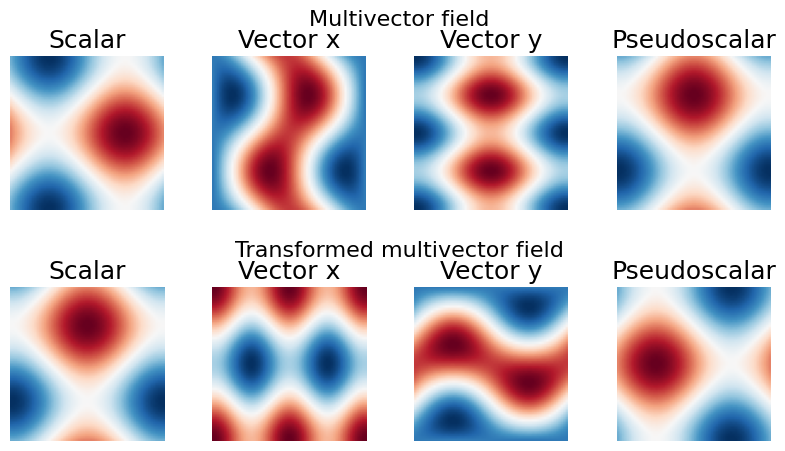

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y", "Pseudoscalar"]
channel = 4

for i in range(4):
    ax[0, i].imshow(mv_gt_batched.tensor[0, i, :, :], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(4):
    ax[1, i].imshow(mv_gt_transformed_in_batched.tensor[0, i, :, :], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(
    -0.1,
    1.2,
    "Multivector field",
    ha="center",
    fontsize=16,
    transform=ax[0, 2].transAxes,
)
plt.text(
    -0.1,
    1.2,
    "Transformed multivector field",
    ha="center",
    fontsize=16,
    transform=ax[1, 2].transAxes,
)
plt.show()

## 3. Apply transformations and compute relative error

In [13]:
# 1) rotation -> 2) convolution

rotated_input = jnp.squeeze(to_mv_jaxed(mv_gt_transformed_in),axis=0)

rotated_condition = pool(rotated_input, create_circular_mask(mask_size))
print(rotated_condition.shape)

out_rotated_conv = to_geometric_tensor_torched(jnp.expand_dims(
    cconv.apply(conv_params, rotated_input, rotated_condition), axis=0), mv_type_out
)

# 2) convolution -> 2) rotation

conv_out = cconv.apply(conv_params, input, condition)
print(conv_out.shape)

out_conv_rotated = to_geometric_tensor_torched(jnp.expand_dims(conv_out, axis=0), mv_type_out).transform(g_out)

print(out_rotated_conv.tensor.shape)
print(out_conv_rotated.tensor.shape)

(5, 4)
(1, 64, 64, 4)
torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64])


In [11]:
# 1) rotation -> 2) convolution

rotated_input = jnp.squeeze(to_mv_jaxed(mv_gt_transformed_in),axis=0)

out_rotated_conv = to_geometric_tensor_torched(jnp.expand_dims(
    cconv.apply(conv_params, rotated_input), axis=0), mv_type_out
)

# 2) convolution -> 2) rotation

conv_out = cconv.apply(conv_params, input)
print(conv_out.shape)

out_conv_rotated = to_geometric_tensor_torched(jnp.expand_dims(conv_out, axis=0), mv_type_out).transform(g_out)

print(out_rotated_conv.tensor.shape)
print(out_conv_rotated.tensor.shape)

new implementation
new implementation
(1, 64, 64, 4)
torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64])


In [13]:
#batched implementation

# 1) rotation -> 2) convolution
rotated_input_batched = to_mv_jaxed(mv_gt_transformed_in_batched)

print(rotated_input_batched.shape)

out_rotated_conv_batched = to_geometric_tensor_torched(
    cconv_batched.apply(conv_params_batched, rotated_input_batched), mv_type_out
)

# 2) convolution -> 2) rotation

conv_out_batched = cconv_batched.apply(conv_params_batched, input_batched)
print(conv_out_batched.shape)

out_conv_rotated_batched = to_geometric_tensor_torched(conv_out_batched, mv_type_out).transform(g_out)

print(out_rotated_conv_batched.tensor.shape)
print(out_conv_rotated_batched.tensor.shape)


(10, 5, 64, 64, 4)
new implementation with batches, x shape: (10, 5, 64, 64, 4)
new implementation with batches, x shape: (10, 5, 64, 64, 4)
(10, 1, 64, 64, 4)
torch.Size([10, 4, 64, 64])
torch.Size([10, 4, 64, 64])


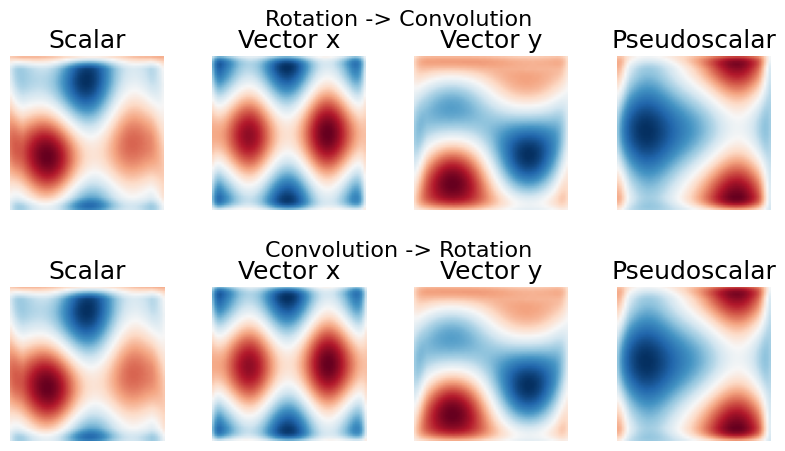

In [14]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y", "Pseudoscalar"]
channel = i

for i in range(4):
    ax[0, i].imshow(out_rotated_conv_batched.tensor[0, i, :, :], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(4):
    ax[1, i].imshow(out_conv_rotated_batched.tensor[0, i, :, :], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(
    -0.1,
    1.2,
    "Rotation -> Convolution",
    ha="center",
    fontsize=16,
    transform=ax[0, 2].transAxes,
)
plt.text(
    -0.1,
    1.2,
    "Convolution -> Rotation",
    ha="center",
    fontsize=16,
    transform=ax[1, 2].transAxes,
)
plt.show()

In [ ]:
# Compute relative error for cconv
print(torch.min(torch.abs(out_rotated_conv.tensor + out_conv_rotated.tensor)))  # Check for zeros
print(torch.max(torch.abs(out_rotated_conv.tensor + out_conv_rotated.tensor)))  # Check overall scale

epsilon = 1e-10  # Small constant
relative_error = torch.abs(
    out_rotated_conv.tensor - out_conv_rotated.tensor
) / (torch.abs(out_rotated_conv.tensor + out_conv_rotated.tensor) + epsilon)

# display up to 5 decimal places
print(f"Relative error (mean): {relative_error.mean().item():.1e}")
print(f"Relative error (max): {relative_error.max().item():.1e}")

In [15]:
#batched implementation

# Compute relative error for cconv
print(torch.min(torch.abs(out_rotated_conv_batched.tensor + out_conv_rotated_batched.tensor)))  # Check for zeros
print(torch.max(torch.abs(out_rotated_conv_batched.tensor + out_conv_rotated_batched.tensor)))  # Check overall scale

epsilon = 1e-10  # Small constant
relative_error_batched = torch.abs(
    out_rotated_conv_batched.tensor - out_conv_rotated_batched.tensor
) / (torch.abs(out_rotated_conv_batched.tensor + out_conv_rotated_batched.tensor) + epsilon)

# display up to 5 decimal places
print(f"Relative error (mean): {relative_error_batched.mean().item():.1e}")
print(f"Relative error (max): {relative_error_batched.max().item():.1e}")

tensor(2.1189e-05)
tensor(3.4155)
Relative error (mean): 5.3e-07
Relative error (max): 3.5e-03


In [22]:
plt.imshow(torch.clip(relative_error[0, 1, :, :], 0, 0.1), cmap="RdBu")
plt.axis("off")
plt.colorbar()
plt.show()

NameError: name 'relative_error' is not defined